In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler

In [3]:
corpus = pd.read_csv("../data/corpus.csv").set_index("date")

corpus = corpus.loc[:"2019-01-01"]

language_features = ["text_cleaned", "title_cleaned"]
supplemental_features = ["is_opec", "is_brent", "is_wti"]

X = corpus[language_features + supplemental_features]

y = corpus["ternary"]

(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, stratify=y, random_state=42)

ros = RandomOverSampler(random_state=42)

X_train, y_train = ros.fit_resample(X_train, y_train)

In [4]:
class MultiPassthrough(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X


identity = FunctionTransformer(lambda x: x)


def custom_scorer(y_true, y_pred, **kwargs):
    eps = 1e-3
    s = np.sum(
        (np.abs(y_true) + np.abs(y_pred))
        * (y_true * y_pred - 1)
        / (1 + y_true * y_pred + eps)
        - (10 * abs(y_pred - y_true)) / (abs(y_true) + eps)
    )

    return s

In [5]:
cv = CountVectorizer()
tfidf = TfidfVectorizer()

rfc = RandomForestClassifier()
logr = LogisticRegression()

mpt = MultiPassthrough()
scorer = make_scorer(custom_scorer)

title_pipe = Pipeline(
    [
        (
            "vectorizer",
            ColumnTransformer([("vectorizer", cv, "title_cleaned")]),
        ),  # the estimators are declared with initial vectorizers and models
        ("model", rfc),  # but these will be replaced by the param dictionaries
    ]
)

article_pipe = Pipeline(
    [
        ("vectorizer", ColumnTransformer([("vectorizer", cv, "text_cleaned")])),
        ("model", rfc),
    ]
)

supplemental_pipe = Pipeline(
    [
        (
            "transformer",
            ColumnTransformer([("transformer", identity, supplemental_features)]),
        ),
        ("passthrough", mpt),
    ]
)

estimators = [
    ("title_pipe", title_pipe),
    ("article_pipe", article_pipe),
    ("supplemental_pipe", supplemental_pipe),
]

final_estimator = logr

model = StackingClassifier(
    estimators=estimators, final_estimator=final_estimator, n_jobs=-1
)

params = {}

gs = GridSearchCV(model, params, n_jobs=-1, verbose=1, cv=2, scoring=scorer)

gs.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2,
             estimator=StackingClassifier(estimators=[('title_pipe',
                                                       Pipeline(steps=[('vectorizer',
                                                                        ColumnTransformer(transformers=[('vectorizer',
                                                                                                         CountVectorizer(),
                                                                                                         'title_cleaned')])),
                                                                       ('model',
                                                                        RandomForestClassifier())])),
                                                      ('article_pipe',
                                                       Pipeline(steps=[('vectorizer',
                                                                        ColumnTransformer(transformers=[('vectorizer',
                                                                                                         CountVectorizer(),
                                                                                                         'text_cleaned')...
                                                      ('supplemental_pipe',
                                                       Pipeline(steps=[('transformer',
                                                                        ColumnTransformer(transformers=[('transformer',
                                                                                                         FunctionTransformer(func=<function <lambda> at 0x7f6e05abd5a0>),
                                                                                                         ['is_opec',
                                                                                                          'is_brent',
                                                                                                          'is_wti'])])),
                                                                       ('passthrough',
                                                                        MultiPassthrough())]))],
                                          final_estimator=LogisticRegression(),
                                          n_jobs=-1),
             n_jobs=-1, param_grid={}, scoring=make_scorer(custom_scorer),
             verbose=1)

In [6]:
gs.score(X_test, y_test)

-1924836.1638361642

In [7]:
len(corpus[corpus["ternary"] == 0]) / len(corpus)

0.4510320184305797

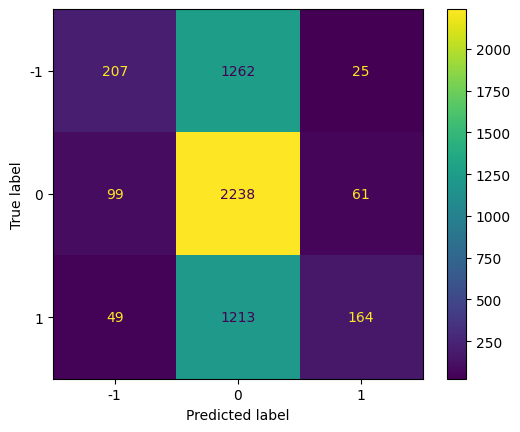

In [8]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test)